# Universidad Autónoma del Estado de México

# Centro Universitario UAEM Zumpango

# Ingenierá En Computación

# Ciencia de los Datos

**Integrantes**: 
* Jesus Enrique Lugo Ramirez
* Daniela Joselin Falcon Sierra
* Eric Carmen Soto

**Profesor**: Dr. Asdrúbal López Chau

**Fecha**: 12 de Diciembre del 2024

Descripcion: Procesamiento de texto.

In [3]:
#Importar Librerias necesarias
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud #biblioteca para nubes de palabras
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pandas as pd
from datetime import datetime
import os
import re
from urllib.parse import urlparse
from collections import Counter




# Recolección de datos. 

In [83]:
# Funcion que elimina las URL's duplicadas en la BD de URL's
def eliminar_urls_duplicadas(archivo_csv):
    # Cargar el archivo CSV
    df = pd.read_csv(archivo_csv, header=None, names=['URL'])
    
    # Eliminar duplicados en la columna 'URL'
    df_sin_duplicados = df.drop_duplicates(subset='URL')
    
    # Sobrescribir el archivo original sin duplicados
    df_sin_duplicados.to_csv(archivo_csv, index=False, header=False)
    
    print(f"Archivo '{archivo_csv}' procesado y sobrescrito sin duplicados.")

# Ejemplo de uso
eliminar_urls_duplicadas("../src/baseDatosURL.csv")

Archivo '../src/baseDatosURL.csv' procesado y sobrescrito sin duplicados.


In [84]:
#Funcion que extrae el nombre del sitio.
def extraer_nombre_sitio(url):
    try:
        dominio = urlparse(url).netloc  # Extrae el dominio completo
        # Toma solo el nombre del sitio (ej. "wikipedia.org" de "es.wikipedia.org")
        partes_dominio = dominio.split('.')
        if len(partes_dominio) > 2:
            return '.'.join(partes_dominio[-2:])  # Ej. "wikipedia.org"
        return dominio
    except Exception as e:
        return "Sitio desconocido"  # En caso de error, devuelve un valor predeterminado

In [85]:
#creacion de un csv que almacena la informacion necesaria.
dfGeneral = pd.DataFrame(columns=["NomArchivo", "Longitud", "Fecha/Hora", "Autor","Titulo","NombreSitio",  "URL", "Contenido"])


In [86]:
#Funcion que agrega filas de datos Generales al CSV de metadatos.
def agregar_fila_csv(fila_datos, nombre_archivo="archivo.csv"):
    # Convierte la fila de datos en un DataFrame de una sola fila
    df_fila = pd.DataFrame([fila_datos])

    # Verifica si el archivo ya existe
    if os.path.isfile(nombre_archivo):
        # Si el archivo existe, agrega la fila sin escribir el encabezado
        df_fila.to_csv(nombre_archivo, mode='a', index=False, header=False)
    else:
        # Si el archivo no existe, crea el archivo con el encabezado
        df_fila.to_csv(nombre_archivo, mode='w', index=False)

In [87]:
#Funcion general que realiza el request y se encarga de obtener y almacenar todos los datos. 
def guardarInfo():
    df = pd.read_csv("../src/baseDatosURL.csv")
    print(df)

    os.makedirs("../archivosTXT", exist_ok=True)
    os.makedirs("../DatosGenerales", exist_ok=True)


    for url in df["URL"]:

        if os.path.exists("../DatosGenerales/DatosGenerales.csv"):
            dfr = pd.read_csv("../DatosGenerales/DatosGenerales.csv")

            if url in dfr["URL"].values:
                print(f"La URL '{url}' ya existe en el archivo CSV. Se omite.")
                continue
        
        try:
            r = requests.get(url, timeout=10)
            r.raise_for_status()  # Lanza una excepción si la solicitud falla
        except requests.exceptions.RequestException as e:
            print(f"No se pudo acceder a la URL: {url}. Error: {e}")
            continue  # Pasa a la siguiente URL si falla
        
        if r.status_code == 200:


            try:

                fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                nombreSitio = extraer_nombre_sitio(url)

                soup = BeautifulSoup(r.content, 'html.parser')

                # Extraer título, autor (si existe) y texto
                titulo = soup.title.get_text() if soup.title else "Sin título"
                autor = soup.find('meta', attrs={'name': 'author'})
                autor = autor['content'] if autor else "Autor desconocido"

                # Extraer el contenido de los párrafos
                parrafos = [p.get_text() for p in soup.find_all('p')]
                contenido = "\n".join(parrafos)
                contenidoCSV = contenido.split()

                if len(contenidoCSV) < 400:
                    print("El contenido no es mayor a 400 palabras en la pagina: ",url )
                    continue
                
                contenidoCSV = " ".join(contenidoCSV[:])

                indice = df[df['URL'] == url].index[0]

                

                nomArchivo = f"Archivo_{indice}.txt"
                rutaArchivo = f"../archivosTXT/Archivo_{indice}.txt"
                nuevaFila = {"NomArchivo":nomArchivo, "Longitud":len(contenido.split()), "Fecha/Hora":fecha_actual, "Autor":autor,"Titulo": titulo,"NombreSitio": nombreSitio,  "URL":url,"Contenido":contenidoCSV}
                agregar_fila_csv(nuevaFila, "../DatosGenerales/DatosGenerales.csv")

                if os.path.exists(rutaArchivo):
                    print(f"El archivo {nomArchivo} ya existe")
                    continue
                
                archivo = open(rutaArchivo, 'w', encoding='utf-8')
                archivo.write(titulo + "\n")
                archivo.write(autor + "\n")
                archivo.write(nombreSitio + "\n\n")
                archivo.write(contenido)
                archivo.close()

            except:
                print("a ocurrido un error")

        else:
            print("No se pudo acceder la URL: ", url)
        

        


guardarInfo()

                                                   URL
0                https://es.wikipedia.org/wiki/ChatGPT
1    https://www.ibm.com/es-es/topics/machine-learning
2       https://www.ibm.com/es-es/topics/deep-learning
3     https://www.ibm.com/es-es/topics/neural-networks
4    https://www.xataka.com/basics/chatgpt-que-como...
..                                                 ...
978                  https://www.bbvaaifactory.com/es/
979  https://www.eleconomista.com.mx/sectorfinancie...
980  https://forbes.com.mx/bbva-expande-su-fabrica-...
981  https://elpais.com/smoda/belleza/2023-12-09/co...
982  https://ceg.es/es/publicaciones/la-inteligenci...

[983 rows x 1 columns]
La URL 'https://es.wikipedia.org/wiki/ChatGPT' ya existe en el archivo CSV. Se omite.
La URL 'https://www.ibm.com/es-es/topics/machine-learning' ya existe en el archivo CSV. Se omite.
La URL 'https://www.ibm.com/es-es/topics/deep-learning' ya existe en el archivo CSV. Se omite.
La URL 'https://www.ibm.com/es-es/top

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


El contenido no es mayor a 400 palabras en la pagina:  https://www.ift.org.mx/transformacion-digital/blog/puede-la-inteligencia-artificial-ayudar-reducir-la-brecha-digital-en-mexico
La URL 'https://www.eleconomista.com.mx/opinion/IA-Generativa-y-la-Brecha-Digital-en-Mexico-Oportunidad-o-Desafio-para-el-Empleo-20240823-0046.html' ya existe en el archivo CSV. Se omite.
La URL 'https://news.un.org/es/story/2024/07/1531666' ya existe en el archivo CSV. Se omite.
La URL 'https://www.uag.mx/es/mediahub/el-papel-de-la-inteligencia-artificial-en-la-brecha-educativa-y-digital-en-mexico/2023-08' ya existe en el archivo CSV. Se omite.
No se pudo acceder a la URL: https://confilegal.com/20240202-opinion-la-nueva-brecha-digital-nacida-de-la-inteligencia-artificial/. Error: 403 Client Error: Forbidden for url: https://confilegal.com/20240202-opinion-la-nueva-brecha-digital-nacida-de-la-inteligencia-artificial/
La URL 'https://www.ilo.org/es/resource/news/cuidado-con-la-brecha-reducir-la-brecha-de-la

# EDA

## Limpieza de Datos

In [4]:
import pandas as pd
from urllib.parse import urlparse

df_metadatos = pd.read_csv("../DatosGenerales/DatosGenerales.csv")  

# Función para extraer el nombre principal del sitio sin las terminaciones ".com", ".net", ".org" y "www"
def extraer_nombre_sitio(url):
    try:
        dominio = urlparse(url).netloc 
        partes_dominio = dominio.split('.')

        # Eliminar "www" si está presente
        if partes_dominio[0] == "www":
            partes_dominio = partes_dominio[1:]  

        # Si contiene "blog", tomar la segunda palabra después del punto
        if "blog" in partes_dominio:
            index_blog = partes_dominio.index("blog")
            if index_blog + 1 < len(partes_dominio):
                return partes_dominio[index_blog + 1]  

        # Definir una lista de terminaciones que no queremos en el nombre
        terminaciones = ["com", "net", "org"]

        # Si el dominio tiene una extensión que queremos eliminar, la descartamos
        if partes_dominio[-1] in terminaciones:
            return partes_dominio[-2]  

        return partes_dominio[0]  

    except Exception as e:
        return "Sitio desconocido"  

# Aplicar la función a la columna "URL" para crear los sitios
df_metadatos['NombreSitio'] = df_metadatos['URL'].apply(extraer_nombre_sitio)

# Reemplazar "Autor desconocido" en la columna "Autor" con el valor de la columna "NombreSitio" en caso de que no exista el nombre del autor
df_metadatos['Autor'] = df_metadatos.apply(lambda row: row['NombreSitio'] if row['Autor'] == "Autor desconocido" else row['Autor'], axis=1)

# Guardar el DataFrame como un archivo CSV
df_metadatos.to_csv('DatosGenerales1.csv', index=False)

# Mostrar el resultado
df_metadatos

,NomArchivo,Longitud,Fecha/Hora,Autor,Titulo,NombreSitio,URL,Contenido
0,Archivo_0.txt,6919,2024-12-01 12:43:00,wikipedia,"ChatGPT - Wikipedia, la enciclopedia libre",wikipedia,https://es.wikipedia.org/wiki/ChatGPT,ChatGPT (acrónimo del inglés Chat Generative P...
1,Archivo_1.txt,3175,2024-12-01 12:43:01,ibm,¿Qué es el machine learning (ML)? | IBM,ibm,https://www.ibm.com/es-es/topics/machine-learning,Dado que el deep learning y el machine learnin...
2,Archivo_2.txt,5149,2024-12-01 12:43:02,ibm,¿Qué es el deep learning? | IBM,ibm,https://www.ibm.com/es-es/topics/deep-learning,Actualizado: 17 junio 2024 Colaboradores: Jim ...
3,Archivo_3.txt,1860,2024-12-01 12:43:02,ibm,¿Qué son las redes neuronales? | IBM,ibm,https://www.ibm.com/es-es/topics/neural-networks,"Una red neuronal es un programa, o modelo, de ..."
4,Archivo_4.txt,1309,2024-12-01 12:43:03,xataka,"ChatGPT: qué es, cómo usarlo y qué puedes hace...",xataka,https://www.xataka.com/basics/chatgpt-que-como...,Yúbal Fernández Vamos a explicarte qué es Chat...
...,...,...,...,...,...,...,...,...
732,Archivo_979.txt,690,2024-12-01 13:20:24,eleconomista,BBVA expande su fábrica de IA a México y Turquía,eleconomista,https://www.eleconomista.com.mx/sectorfinancie...,Lectura 3:00 min A través de fábrica de IA se ...
733,Archivo_981.txt,937,2024-12-01 13:20:27,Maria Ovelar,¿Cómo está cambiando la Inteligencia Artificia...,elpais,https://elpais.com/smoda/belleza/2023-12-09/co...,La Inteligencia Artificial aplicada a la medic...
734,Archivo_982.txt,562,2024-12-01 13:20:28,ceg,La Inteligencia Artificial vs la Igualdad de g...,ceg,https://ceg.es/es/publicaciones/la-inteligenci...,La Inteligencia Artificial vs la Igualdad de g...
735,Archivo_607.txt,1510,2024-12-01 16:02:07,unesco,Inteligencia artificial: entre el mito y la re...,unesco,https://courier.unesco.org/es/articles/intelig...,El Correo de la UNESCO El Correo de la UNESCO ...


In [5]:
# Descargar stopwords en español y lectura de csv con metadatos.
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gamen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Función de limpieza de texto y elimacion caracteres especiales
def limpiar_texto(texto):
    texto = str(texto)
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar puntuación
    palabras = texto.split()
    palabras_limpias = [palabra for palabra in palabras if palabra not in stop_words]
    return " ".join(palabras_limpias)

# Aplicar la limpieza al contenido de todos los documentos
df_metadatos['Contenido'] = df_metadatos['Contenido'].apply(limpiar_texto)

# Eliminar columnas con todos los valores NaN
df_metadatos = df_metadatos.dropna(axis=1, how='all')

# Guardar el DataFrame como un archivo CSV
df_metadatos.to_csv("metadatos.csv", index=False, encoding='utf-8')

df_metadatos

,NomArchivo,Longitud,Fecha/Hora,Autor,Titulo,NombreSitio,URL,Contenido
0,Archivo_0.txt,6919,2024-12-01 12:43:00,wikipedia,"ChatGPT - Wikipedia, la enciclopedia libre",wikipedia,https://es.wikipedia.org/wiki/ChatGPT,chatgpt acrónimo inglés chat generative pretra...
1,Archivo_1.txt,3175,2024-12-01 12:43:01,ibm,¿Qué es el machine learning (ML)? | IBM,ibm,https://www.ibm.com/es-es/topics/machine-learning,dado deep learning machine learning tienden ut...
2,Archivo_2.txt,5149,2024-12-01 12:43:02,ibm,¿Qué es el deep learning? | IBM,ibm,https://www.ibm.com/es-es/topics/deep-learning,actualizado junio colaboradores jim holdsworth...
3,Archivo_3.txt,1860,2024-12-01 12:43:02,ibm,¿Qué son las redes neuronales? | IBM,ibm,https://www.ibm.com/es-es/topics/neural-networks,red neuronal programa modelo machine learning ...
4,Archivo_4.txt,1309,2024-12-01 12:43:03,xataka,"ChatGPT: qué es, cómo usarlo y qué puedes hace...",xataka,https://www.xataka.com/basics/chatgpt-que-como...,yúbal fernández vamos explicarte chatgpt puede...
...,...,...,...,...,...,...,...,...
732,Archivo_979.txt,690,2024-12-01 13:20:24,eleconomista,BBVA expande su fábrica de IA a México y Turquía,eleconomista,https://www.eleconomista.com.mx/sectorfinancie...,lectura min través fábrica ia investigan últim...
733,Archivo_981.txt,937,2024-12-01 13:20:27,Maria Ovelar,¿Cómo está cambiando la Inteligencia Artificia...,elpais,https://elpais.com/smoda/belleza/2023-12-09/co...,inteligencia artificial aplicada medicina ciru...
734,Archivo_982.txt,562,2024-12-01 13:20:28,ceg,La Inteligencia Artificial vs la Igualdad de g...,ceg,https://ceg.es/es/publicaciones/la-inteligenci...,inteligencia artificial vs igualdad género ben...
735,Archivo_607.txt,1510,2024-12-01 16:02:07,unesco,Inteligencia artificial: entre el mito y la re...,unesco,https://courier.unesco.org/es/articles/intelig...,correo unesco correo unesco artículo jeangabri...


In [7]:
df_metadatos.head(20) 

,NomArchivo,Longitud,Fecha/Hora,Autor,Titulo,NombreSitio,URL,Contenido
0,Archivo_0.txt,6919,2024-12-01 12:43:00,wikipedia,"ChatGPT - Wikipedia, la enciclopedia libre",wikipedia,https://es.wikipedia.org/wiki/ChatGPT,chatgpt acrónimo inglés chat generative pretra...
1,Archivo_1.txt,3175,2024-12-01 12:43:01,ibm,¿Qué es el machine learning (ML)? | IBM,ibm,https://www.ibm.com/es-es/topics/machine-learning,dado deep learning machine learning tienden ut...
2,Archivo_2.txt,5149,2024-12-01 12:43:02,ibm,¿Qué es el deep learning? | IBM,ibm,https://www.ibm.com/es-es/topics/deep-learning,actualizado junio colaboradores jim holdsworth...
3,Archivo_3.txt,1860,2024-12-01 12:43:02,ibm,¿Qué son las redes neuronales? | IBM,ibm,https://www.ibm.com/es-es/topics/neural-networks,red neuronal programa modelo machine learning ...
4,Archivo_4.txt,1309,2024-12-01 12:43:03,xataka,"ChatGPT: qué es, cómo usarlo y qué puedes hace...",xataka,https://www.xataka.com/basics/chatgpt-que-como...,yúbal fernández vamos explicarte chatgpt puede...
5,Archivo_5.txt,2074,2024-12-01 12:43:03,ibm,¿Qué es la Inteligencia Artificial (IA)? | IBM,ibm,https://www.ibm.com/es-es/topics/artificial-in...,inteligencia artificial ia tecnología permite ...
6,Archivo_6.txt,664,2024-12-01 12:43:04,wikipedia,"Aprendizaje profundo - Wikipedia, la enciclope...",wikipedia,https://es.wikipedia.org/wiki/Aprendizaje_prof...,aprendizaje profundo inglés deep learning conj...
7,Archivo_7.txt,1815,2024-12-01 12:43:04,wikipedia,"Aprendizaje automático - Wikipedia, la enciclo...",wikipedia,https://es.wikipedia.org/wiki/Aprendizaje_auto...,aprendizaje automático aa llamado automatizado...
8,Archivo_8.txt,657,2024-12-01 12:43:04,unir,"¿Qué es Deep Learning? En qué consiste, ejempl...",unir,https://www.unir.net/revista/ingenieria/deep-l...,ingeniería tecnología unir revista plena big d...
9,Archivo_9.txt,1347,2024-12-01 12:43:08,sas,¿Qué es deep learning? | SAS,sas,https://www.sas.com/es_mx/insights/analytics/d...,ir contenido principal aprender sas demanda co...


## Nube de Palabras General

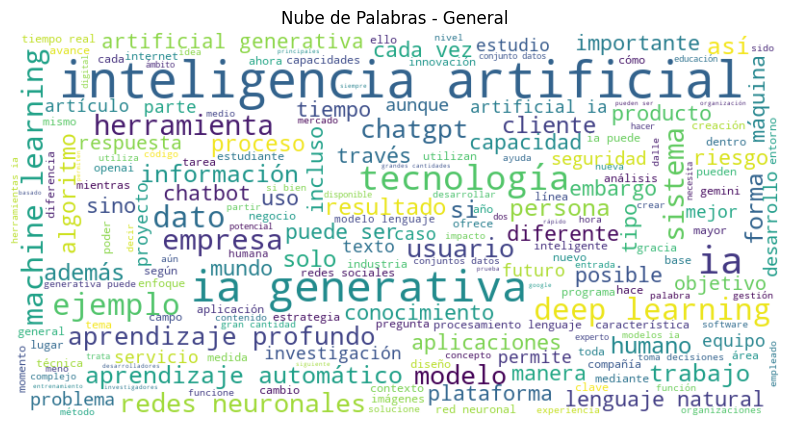

In [8]:
#Funcion para mostrar nube de palabras general. 
def mostrar_nube_palabras(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.show()

texto_total = " ".join(df_metadatos['Contenido'])
mostrar_nube_palabras(texto_total, "Nube de Palabras - General")

In [9]:
#Identificacion de autores y fuentes mas frecuentes y su frecuencia.
df_gere = pd.read_csv('metadatos.csv')

# 1. Identificar autores y fuentes más frecuentes del dataframe
autores_frecuentes = df_gere['Autor'].value_counts().head(10)
sitios_frecuentes = df_gere['NombreSitio'].value_counts().head(10)

print("Autores más frecuentes:\n", autores_frecuentes)
print("\nSitios más frecuentes:\n", sitios_frecuentes)

# 2. Análisis de frecuencia de palabras por sitio y por autor
def obtener_frecuencia_palabras(grupo):
    todas_palabras = " ".join(grupo).split()
    frecuencia_palabras = Counter(todas_palabras)
    return frecuencia_palabras

Autores más frecuentes:
 Autor
bbc              38
ecanorea         29
elfinanciero     21
ibm              15
luciaclemares    12
xataka           10
BBVA             10
amazon           10
eleconomista      9
wikipedia         7
Name: count, dtype: int64

Sitios más frecuentes:
 NombreSitio
bbc              38
plainconcepts    33
elfinanciero     21
telefonica       19
cnn              16
ibm              15
elpais           12
bbva             10
xataka           10
amazon           10
Name: count, dtype: int64


## Grafica de Autores y sitios más frecuentes.

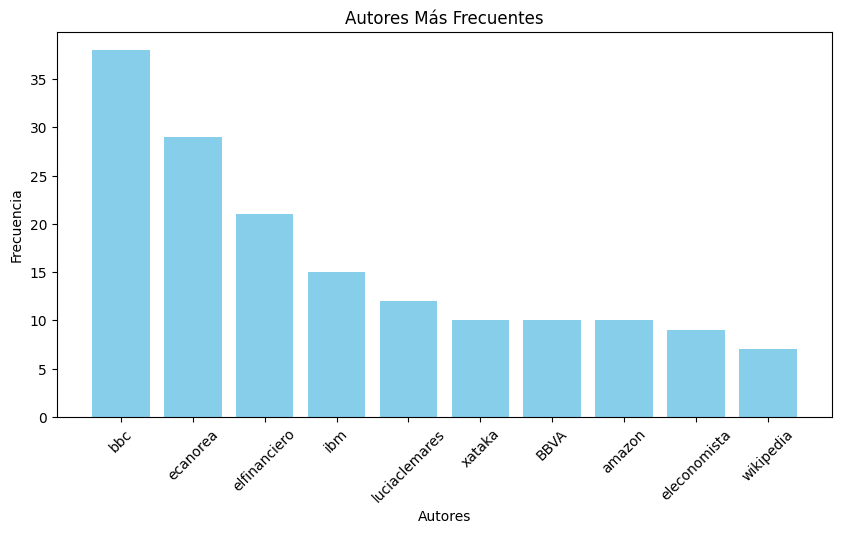

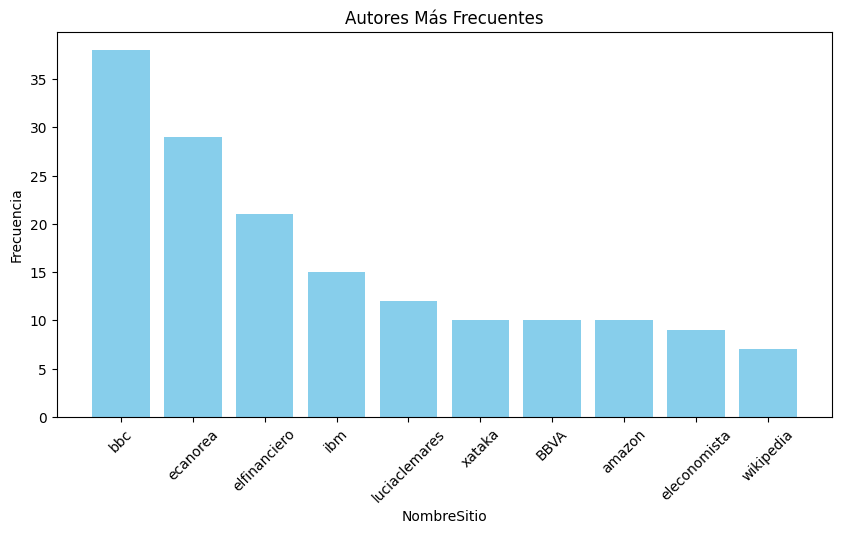

In [10]:
# Cargar los datos
df_gere = pd.read_csv('metadatos.csv')

# Identificar autores y sitios más frecuentes
autores_frecuentes = df_gere['Autor'].value_counts().head(10)
sitios_frecuentes = df_gere['NombreSitio'].value_counts().head(10)

# Función para graficar frecuencia de palabras en gráfico de barras
def graficar_frecuencia(elementos, titulo, xlabel):
    nombres, frecuencias = zip(*elementos.items())
    plt.figure(figsize=(10, 5))
    plt.bar(nombres, frecuencias, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    plt.title(titulo)
    plt.xticks(rotation=45)
    plt.show()

# Gráfica para autores más frecuentes
graficar_frecuencia(autores_frecuentes, "Autores Más Frecuentes", "Autores")
graficar_frecuencia(autores_frecuentes, "Autores Más Frecuentes", "NombreSitio")


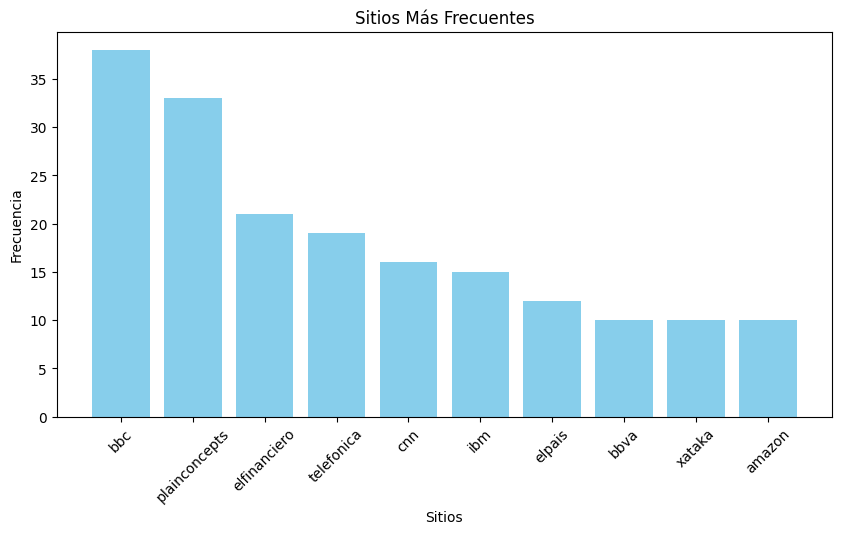

In [11]:
# Gráfica para sitios más frecuentes
graficar_frecuencia(sitios_frecuentes, "Sitios Más Frecuentes", "Sitios")

## Nube de palabras de los sitios que mas hablan del tema.

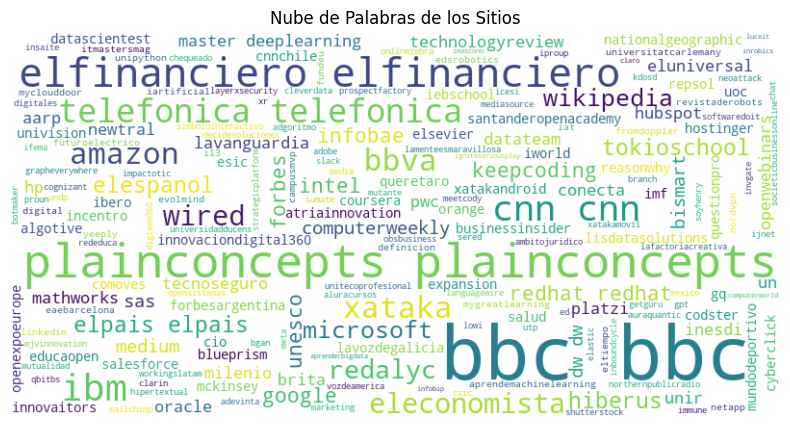

In [12]:
# Función para generar y mostrar nubes de palabras
def mostrar_nube_palabras(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.show()

# Nube de palabras general
texto_total = " ".join(df_gere['NombreSitio'])
mostrar_nube_palabras(texto_total, "Nube de Palabras de los Sitios")

## Nube de palabras de los autores que más hablan del tema.

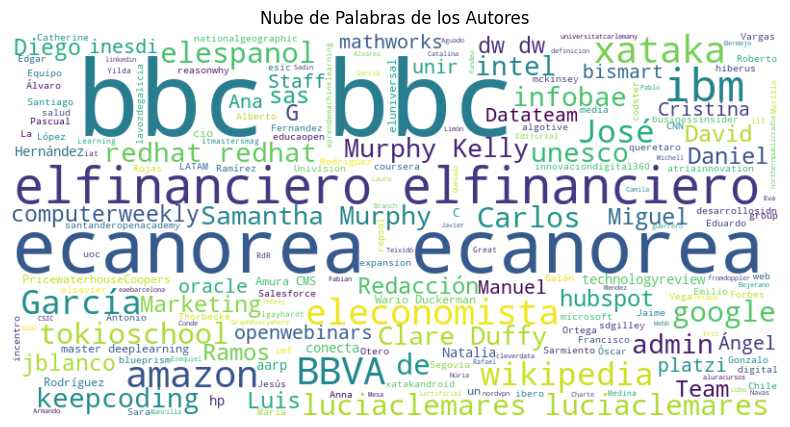

In [13]:
# Función para generar y mostrar nubes de palabras
def mostrar_nube_palabras(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.show()

texto_total = " ".join(df_gere['Autor'].astype(str))


# Reducir la frecuencia de "Autor desconocido" reemplazando algunas ocurrencias
texto_total = texto_total.replace("Autor desconocido", "", 100)
texto_total = texto_total.replace("desconocido Autor", "") #No salga

mostrar_nube_palabras(texto_total, "Nube de Palabras de los Autores")


####Frecuencia de palabras del contenido de los sitios 

# Análisis de sentimiento

In [14]:
df_metadatos

,NomArchivo,Longitud,Fecha/Hora,Autor,Titulo,NombreSitio,URL,Contenido
0,Archivo_0.txt,6919,2024-12-01 12:43:00,wikipedia,"ChatGPT - Wikipedia, la enciclopedia libre",wikipedia,https://es.wikipedia.org/wiki/ChatGPT,chatgpt acrónimo inglés chat generative pretra...
1,Archivo_1.txt,3175,2024-12-01 12:43:01,ibm,¿Qué es el machine learning (ML)? | IBM,ibm,https://www.ibm.com/es-es/topics/machine-learning,dado deep learning machine learning tienden ut...
2,Archivo_2.txt,5149,2024-12-01 12:43:02,ibm,¿Qué es el deep learning? | IBM,ibm,https://www.ibm.com/es-es/topics/deep-learning,actualizado junio colaboradores jim holdsworth...
3,Archivo_3.txt,1860,2024-12-01 12:43:02,ibm,¿Qué son las redes neuronales? | IBM,ibm,https://www.ibm.com/es-es/topics/neural-networks,red neuronal programa modelo machine learning ...
4,Archivo_4.txt,1309,2024-12-01 12:43:03,xataka,"ChatGPT: qué es, cómo usarlo y qué puedes hace...",xataka,https://www.xataka.com/basics/chatgpt-que-como...,yúbal fernández vamos explicarte chatgpt puede...
...,...,...,...,...,...,...,...,...
732,Archivo_979.txt,690,2024-12-01 13:20:24,eleconomista,BBVA expande su fábrica de IA a México y Turquía,eleconomista,https://www.eleconomista.com.mx/sectorfinancie...,lectura min través fábrica ia investigan últim...
733,Archivo_981.txt,937,2024-12-01 13:20:27,Maria Ovelar,¿Cómo está cambiando la Inteligencia Artificia...,elpais,https://elpais.com/smoda/belleza/2023-12-09/co...,inteligencia artificial aplicada medicina ciru...
734,Archivo_982.txt,562,2024-12-01 13:20:28,ceg,La Inteligencia Artificial vs la Igualdad de g...,ceg,https://ceg.es/es/publicaciones/la-inteligenci...,inteligencia artificial vs igualdad género ben...
735,Archivo_607.txt,1510,2024-12-01 16:02:07,unesco,Inteligencia artificial: entre el mito y la re...,unesco,https://courier.unesco.org/es/articles/intelig...,correo unesco correo unesco artículo jeangabri...


# Se genera el análisis de polaridad y clasificación de sentimientos

In [15]:
!pip install nltk


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\gamen\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
# codigo que obtiene la clasificacion y polaridad de sentimientos del contenido.
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargar recursos de VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def analizar_sentimiento(texto):
    sentimiento = sia.polarity_scores(texto)
    return sentimiento['compound']  # Se usa 'compound' para obtener el puntaje global

df_metadatos['Polaridad'] = df_metadatos['Contenido'].apply(analizar_sentimiento)

def clasificar_sentimiento(polaridad):
    if polaridad >= 0.05:
        return "Positivo"
    elif polaridad <= -0.05:
        return "Negativo"
    else:
        return "Neutral"
    
    
df_metadatos['Clasificación'] = df_metadatos['Polaridad'].apply(clasificar_sentimiento)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gamen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
df_metadatos

,NomArchivo,Longitud,Fecha/Hora,Autor,Titulo,NombreSitio,URL,Contenido,Polaridad,Clasificación
0,Archivo_0.txt,6919,2024-12-01 12:43:00,wikipedia,"ChatGPT - Wikipedia, la enciclopedia libre",wikipedia,https://es.wikipedia.org/wiki/ChatGPT,chatgpt acrónimo inglés chat generative pretra...,0.9670,Positivo
1,Archivo_1.txt,3175,2024-12-01 12:43:01,ibm,¿Qué es el machine learning (ML)? | IBM,ibm,https://www.ibm.com/es-es/topics/machine-learning,dado deep learning machine learning tienden ut...,0.9169,Positivo
2,Archivo_2.txt,5149,2024-12-01 12:43:02,ibm,¿Qué es el deep learning? | IBM,ibm,https://www.ibm.com/es-es/topics/deep-learning,actualizado junio colaboradores jim holdsworth...,0.9643,Positivo
3,Archivo_3.txt,1860,2024-12-01 12:43:02,ibm,¿Qué son las redes neuronales? | IBM,ibm,https://www.ibm.com/es-es/topics/neural-networks,red neuronal programa modelo machine learning ...,0.0258,Neutral
4,Archivo_4.txt,1309,2024-12-01 12:43:03,xataka,"ChatGPT: qué es, cómo usarlo y qué puedes hace...",xataka,https://www.xataka.com/basics/chatgpt-que-como...,yúbal fernández vamos explicarte chatgpt puede...,0.6908,Positivo
...,...,...,...,...,...,...,...,...,...,...
732,Archivo_979.txt,690,2024-12-01 13:20:24,eleconomista,BBVA expande su fábrica de IA a México y Turquía,eleconomista,https://www.eleconomista.com.mx/sectorfinancie...,lectura min través fábrica ia investigan últim...,0.0000,Neutral
733,Archivo_981.txt,937,2024-12-01 13:20:27,Maria Ovelar,¿Cómo está cambiando la Inteligencia Artificia...,elpais,https://elpais.com/smoda/belleza/2023-12-09/co...,inteligencia artificial aplicada medicina ciru...,0.6249,Positivo
734,Archivo_982.txt,562,2024-12-01 13:20:28,ceg,La Inteligencia Artificial vs la Igualdad de g...,ceg,https://ceg.es/es/publicaciones/la-inteligenci...,inteligencia artificial vs igualdad género ben...,0.3182,Positivo
735,Archivo_607.txt,1510,2024-12-01 16:02:07,unesco,Inteligencia artificial: entre el mito y la re...,unesco,https://courier.unesco.org/es/articles/intelig...,correo unesco correo unesco artículo jeangabri...,0.8360,Positivo


# Gráfico de la distribución de las opiniones 

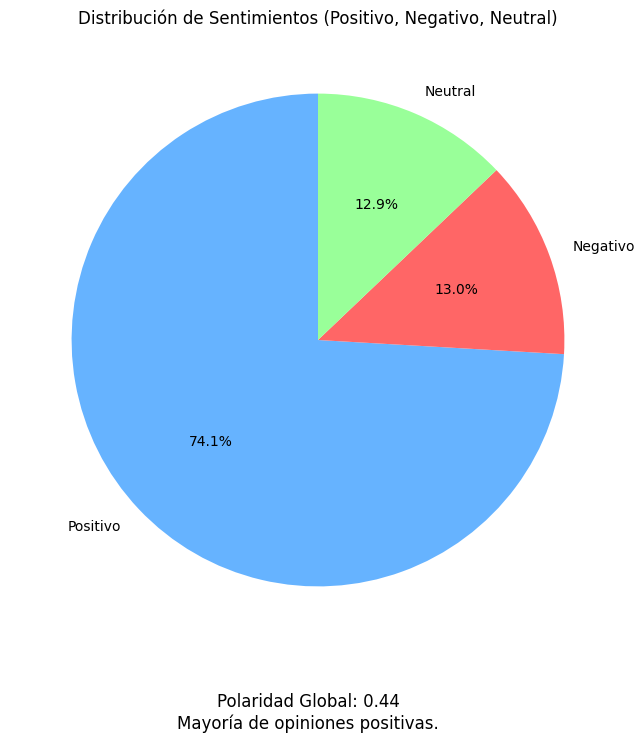

In [18]:
import matplotlib.pyplot as plt
import pandas as pd


polaridad_global = df_metadatos['Polaridad'].mean()

if polaridad_global > 0:
    significado_polaridad = "Mayoría de opiniones positivas."
elif polaridad_global < 0:
    significado_polaridad = "Mayoría de opiniones negativas."
else:
    significado_polaridad = "Opiniones neutrales en su mayoría."

sentimiento_count = df_metadatos['Clasificación'].value_counts()

# Crear gráfico de pastel
plt.figure(figsize=(8, 8))
sentimiento_count.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666', '#99ff99'])

# Título
plt.title('Distribución de Sentimientos (Positivo, Negativo, Neutral)')

# Agregar texto con la polaridad global y su interpretación
plt.figtext(0.5, 0.01, f'Polaridad Global: {polaridad_global:.2f}\n{significado_polaridad}', ha='center', fontsize=12, color='black')
plt.ylabel('')
plt.show()


# Análisis por fuente

In [19]:
# Análisis por fuente
resultados_por_fuente = df_metadatos.groupby('NombreSitio')['Polaridad'].agg(['mean', 'std', 'count'])
print(resultados_por_fuente)

                mean       std  count
NombreSitio                          
20minutos     0.4404       NaN      1
aarp          0.9896  0.006928      3
adeprin       0.9201       NaN      1
adevinta      0.3182       NaN      1
adgoritmo     0.9648       NaN      1
...              ...       ...    ...
xatakandroid  0.4180  0.591141      2
xr-marketing  0.9524       NaN      1
yeeply        0.7506       NaN      1
zeus          0.6369       NaN      1
zscaler       0.9524       NaN      1

[383 rows x 3 columns]


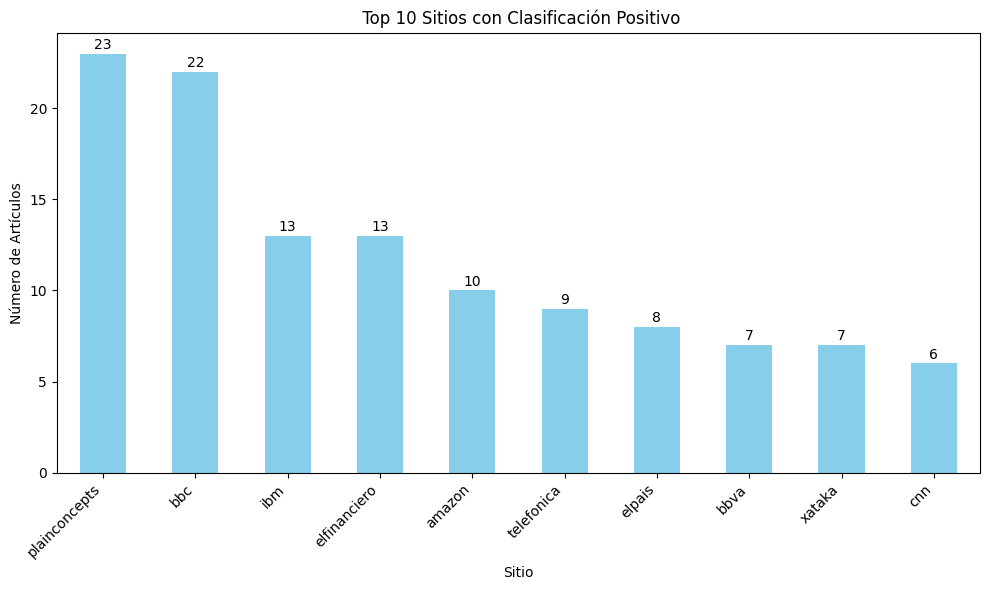

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

def graficar_top_sitios(df_sentiment, clasificacion, titulo):
    # Filtramos el DataFrame por la clasificación
    df_filtrado = df_sentiment[df_sentiment['Clasificación'] == clasificacion]
    
    # Contamos el número de artículos por cada sitio
    conteo_sitios = df_filtrado['NombreSitio'].value_counts().head(10)
    
    # Generamos la gráfica de barras
    plt.figure(figsize=(10, 6))
    ax = conteo_sitios.plot(kind='bar', color='skyblue')
    
    # Agregar el número de artículos encima de cada barra
    for i, v in enumerate(conteo_sitios):
        ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)  # Ajusta la posición del texto
    
    # Títulos y etiquetas
    plt.title(f' Top 10 Sitios con Clasificación {clasificacion}')
    plt.xlabel('Sitio')
    plt.ylabel('Número de Artículos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

graficar_top_sitios(df_metadatos, 'Positivo', 'Top 10 Sitios Positivos')



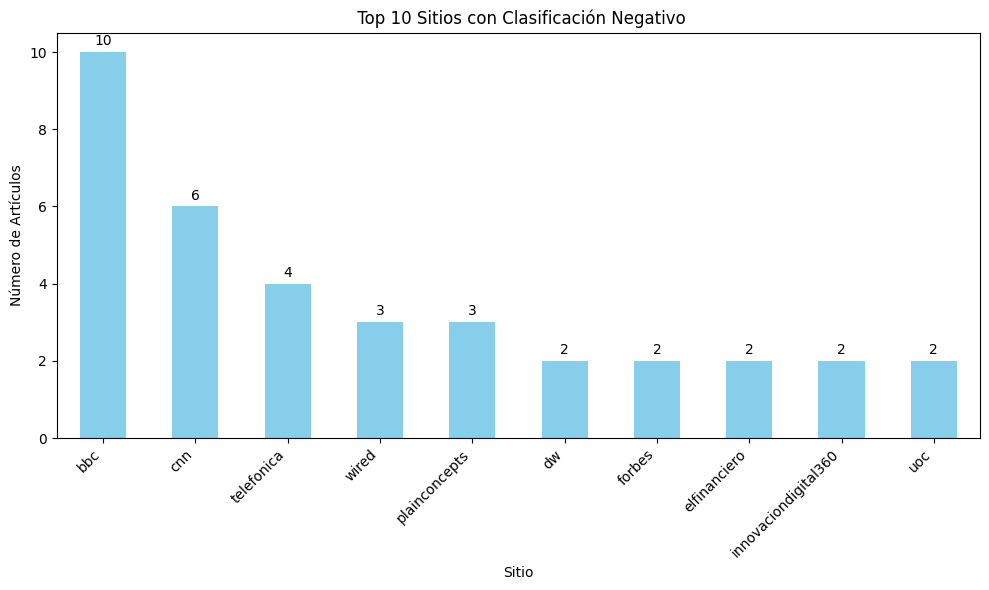

In [21]:
graficar_top_sitios(df_metadatos, 'Negativo', 'Top 10 Sitios Negativos')

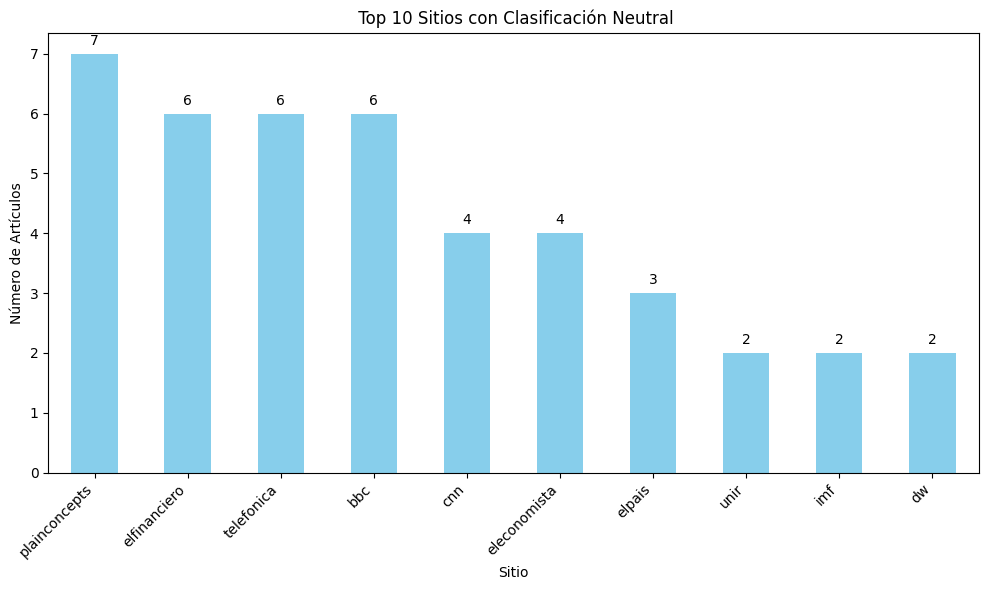

In [22]:
graficar_top_sitios(df_metadatos, 'Neutral', 'Top 10 Sitios Neutrales')

# Análisis por Autor

In [23]:
# Análisis por autor
resultados_por_autor = df_metadatos.groupby('Autor')['Polaridad'].agg(['mean', 'std', 'count'])
print(resultados_por_autor)

                          mean  std  count
Autor                                     
20minutos               0.4404  NaN      1
AFP                     0.9081  NaN      1
Adgoritmo Team          0.9648  NaN      1
Admin                   0.6705  NaN      1
Admin Vivelibre         0.4019  NaN      1
...                        ...  ...    ...
Álvaro Cuevas García    0.8555  NaN      1
Álvaro Vázquez          0.8591  NaN      1
Ángel Aller             0.4215  NaN      1
Óscar Condés Molinero   0.1280  NaN      1
Óscar San José Herrero  0.4019  NaN      1

[449 rows x 3 columns]


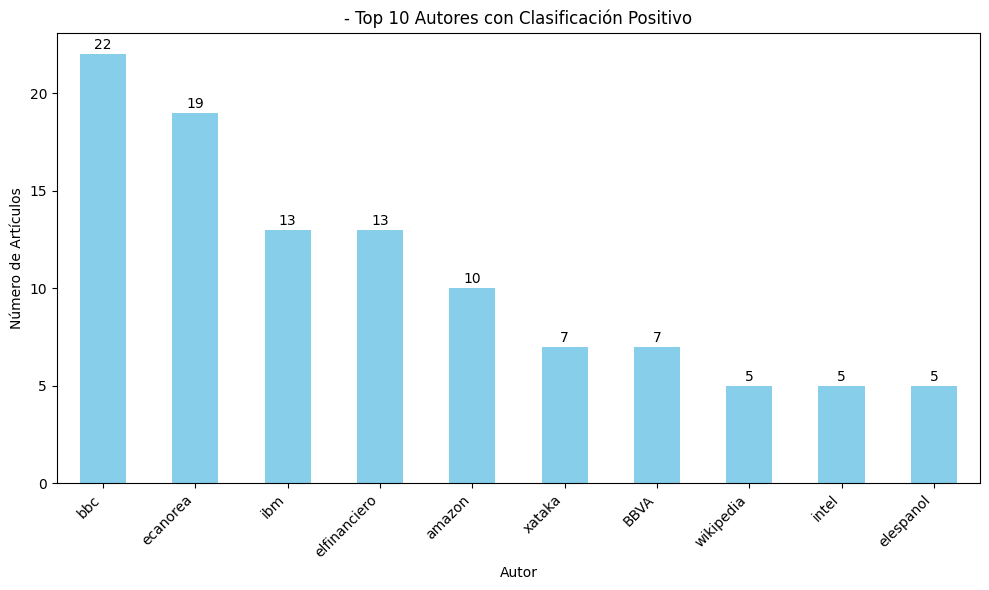

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def graficar_top_autores(df_sentiment, clasificacion, titulo):
    # Filtramos el DataFrame por la clasificación
    df_filtrado = df_sentiment[df_sentiment['Clasificación'] == clasificacion]
    
    # Contamos el número de artículos por cada autor
    conteo_autores = df_filtrado['Autor'].value_counts().head(10)
    
    # Generamos la gráfica de barras
    plt.figure(figsize=(10, 6))
    ax = conteo_autores.plot(kind='bar', color='skyblue')
    
    # Agregar el número de artículos encima de cada barra
    for i, v in enumerate(conteo_autores):
        ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)  # Ajusta la posición del texto
    
    # Títulos y etiquetas
    plt.title(f'- Top 10 Autores con Clasificación {clasificacion}')
    plt.xlabel('Autor')
    plt.ylabel('Número de Artículos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso de la función para la clasificación "Positivo"
graficar_top_autores(df_metadatos, 'Positivo', 'Top 10 Autores Positivos')



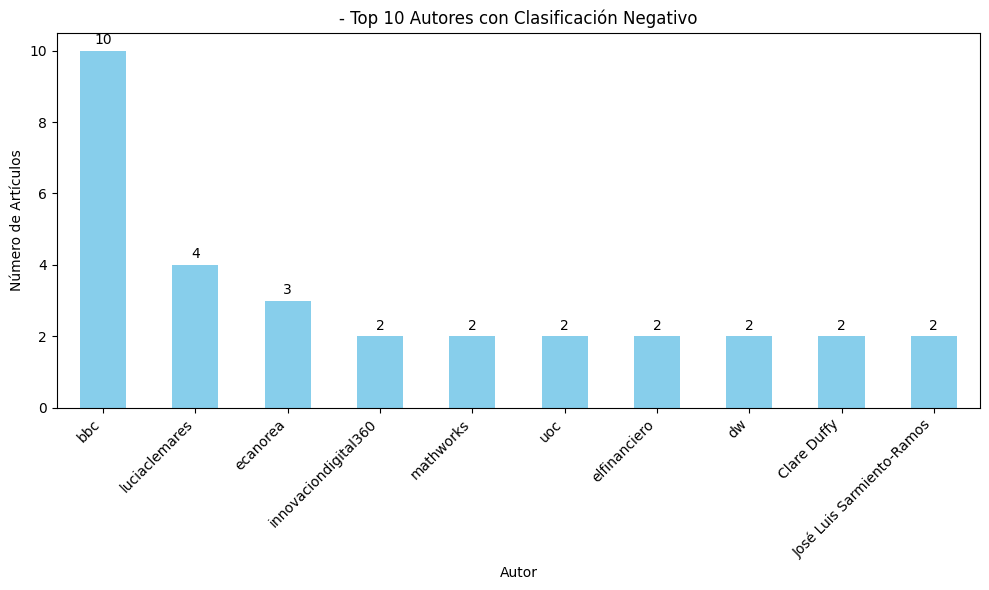

In [25]:
graficar_top_autores(df_metadatos, 'Negativo', 'Top 10 Autores Negativos')


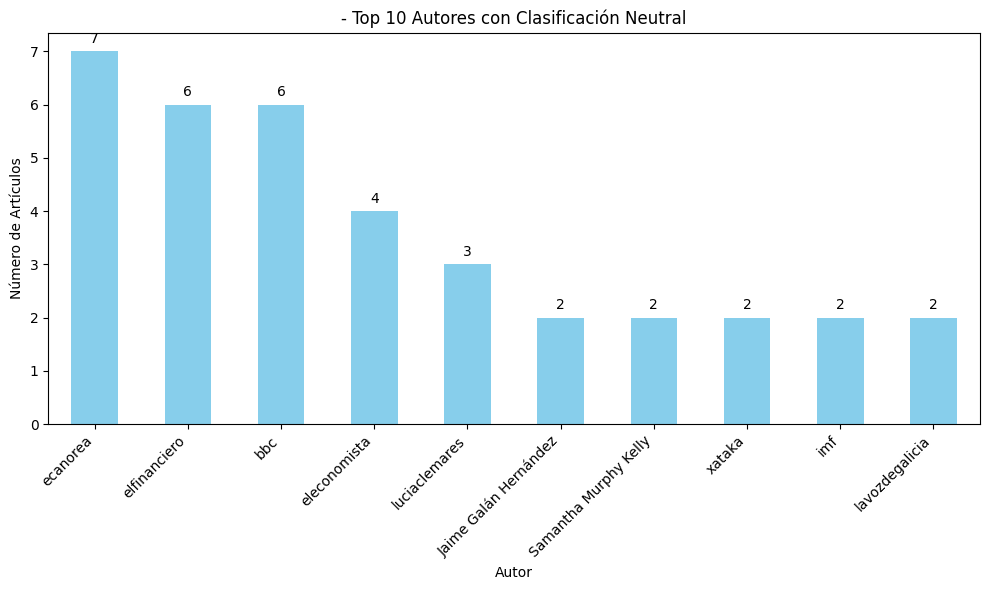

In [26]:
graficar_top_autores(df_metadatos, 'Neutral', 'Top 10 Autores Neutrales')

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

def graficar_topicos_burbujas(df_sentiment, clasificacion, titulo):
    # Filtrar el DataFrame por clasificación
    df_filtrado = df_sentiment[df_sentiment['Clasificación'] == clasificacion]
    
    # Contar el número de opiniones por título
    conteo_topicos = df_filtrado['Titulo'].value_counts().head(10)
    
    # Crear DataFrame para el gráfico
    df_burbujas = pd.DataFrame({
        'Tópico': conteo_topicos.index,
        'Número de Opiniones': conteo_topicos.values,
        'Tamaño': conteo_topicos.values  # Usaremos el mismo valor para el tamaño de la burbuja
    })
    
    # Generar el gráfico de burbujas
    plt.figure(figsize=(10, 6))
    plt.scatter(
        x=df_burbujas['Tópico'],
        y=df_burbujas['Número de Opiniones'],
        s=df_burbujas['Tamaño'] * 50,  # Escalamos el tamaño de las burbujas
        alpha=0.6,
        color='skyblue',
        edgecolors='black'
    )
    
    # Añadir etiquetas y título
    for i in range(len(df_burbujas)):
        plt.text(
            i, 
            df_burbujas['Número de Opiniones'][i] + 0.5,
            str(df_burbujas['Número de Opiniones'][i]),
            ha='center', va='bottom', fontsize=9
        )
    
    plt.title(f'{titulo} - Tópicos con más Opiniones {clasificacion}')
    plt.xlabel('Tópico')
    plt.ylabel('Número de Opiniones')
    plt.xticks(range(len(df_burbujas['Tópico'])), df_burbujas['Tópico'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\3048146213.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


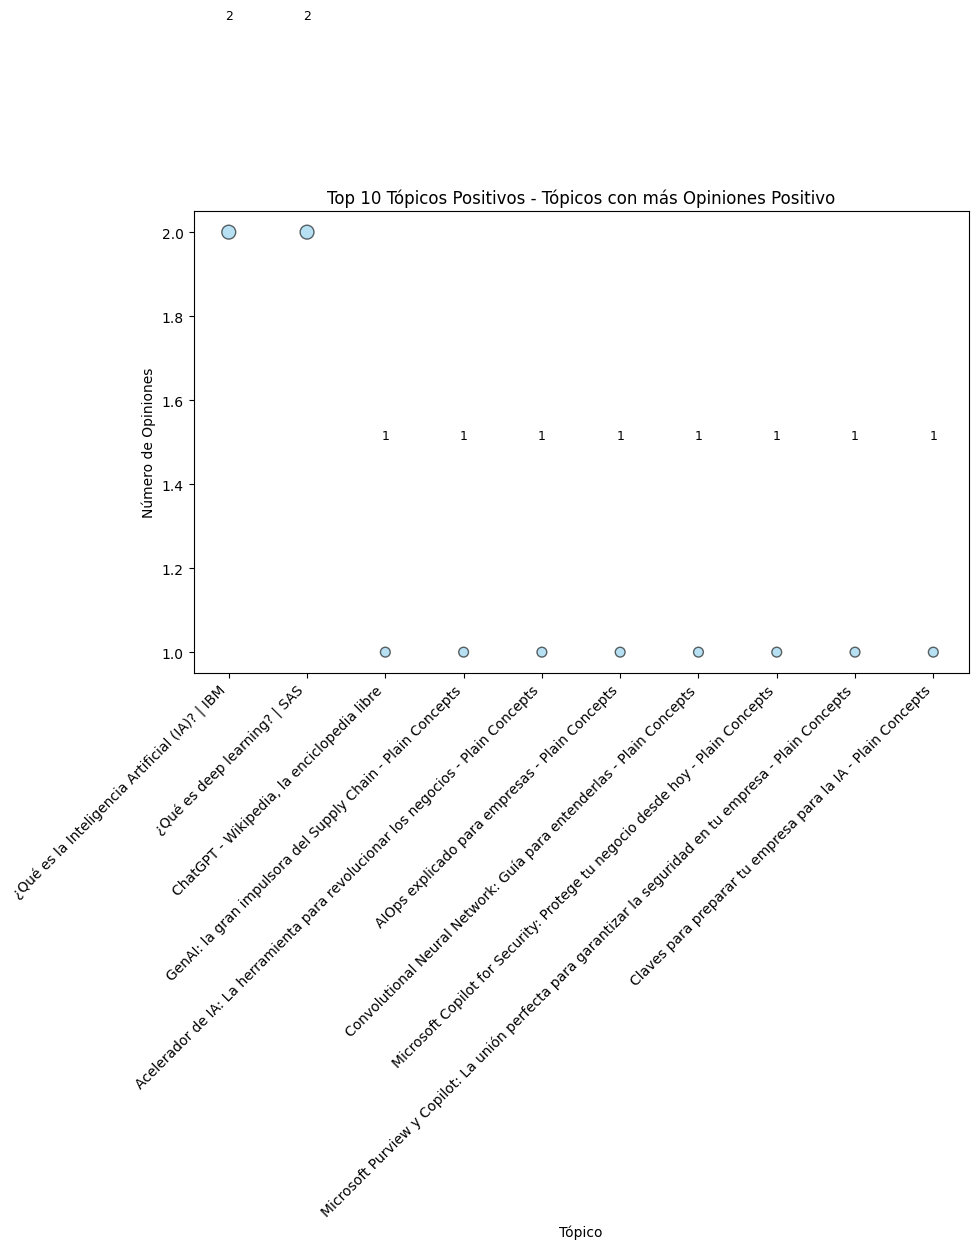

In [28]:
# Generar el gráfico para opiniones positivas
graficar_topicos_burbujas(df_metadatos, 'Positivo', 'Top 10 Tópicos Positivos')



# Modelado de tópicos

In [29]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy

In [30]:
nltk.download('stopwords')
stop_words = stopwords.words('spanish')
nltk.download('punkt_tab')
nlp = spacy.load('es_core_news_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gamen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gamen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [31]:
# Lista personalizada de palabras a eliminar
custom_stopwords = [ 'getty', 'bbc', 'fuente', 'imagen', 'gov', 'línea', '00', '57', 'rcd', '6013323400' ,'li', 'acciona', 'lt', 'gt', 'amp', 'bbc', 'contenido', 'fuente', 'imagen', 'getty', 'images', 'correo', 'electrónico', 'youtube', 'amp', 'línea', 'rcd', 'atención', 'acciona', 'bizum', 'manos' ]

# Función para limpiar y tokenizar los textos
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())  # Convertir a minúsculas y tokenizar
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and t not in custom_stopwords]
    return tokens

In [32]:
def plot_topic_distribution(data, title, xlabel, ylabel):
    # Crear la paleta de colores
    palette = sns.color_palette("hls", 8)

    # Graficar los datos con la paleta personalizada
    sns.barplot(
        x=list(data.values()),
        y=list(data.keys()),
        palette=palette
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [33]:
# Función para obtener la distribución de palabras del tema más mencionado
def get_topic_distribution_LDA(data, num_topics=5):
    dictionary = corpora.Dictionary(data['tokens'])
    corpus = [dictionary.doc2bow(text) for text in data['tokens']]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    topics = lda.show_topics(num_topics=num_topics, formatted=False)

    # Obtener el tema más relevante (primer tema del modelo)
    topic_words = topics[0][1]  # Lista de (palabra, probabilidad)
    return {word: prob for word, prob in topic_words}


# Aplicar LDA para cada autor
def get_topics_by_author_LDA(author_data, num_topics=5):
    # Crear diccionario y corpus para LDA
    dictionary = corpora.Dictionary(author_data['tokens'])
    corpus = [dictionary.doc2bow(text) for text in author_data['tokens']]

    # Aplicar el modelo LDA
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

    topics = lda.print_topics(num_topics=num_topics)
    return topics


# Aplicar LDA para cada fuente
def get_topics_by_source(source_data, num_topics=5):
    # Crear diccionario y corpus para LDA
    dictionary = corpora.Dictionary(source_data['tokens'])
    corpus = [dictionary.doc2bow(text) for text in source_data['tokens']]

    # Aplicar el modelo LDA
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

    topics = lda.print_topics(num_topics=num_topics)
    return topics

In [34]:
# Lista personalizada de palabras a eliminar
palabras_excluir = {"ser", "si", "puede", "dice", "hacer", "ver"}

# Función para filtrar palabras relevantes (excluyendo palabras específicas)
def filtrar_palabras_relevantes(texto):
    doc = nlp(texto)
    palabras_relevantes = [
        token.text.lower()
        for token in doc
        if token.is_alpha and  # Solo palabras (descartar números y símbolos)
        token.pos_ not in {'VERB', 'AUX', 'ADP', 'CONJ', 'PRON'} and  # Excluir verbos y otras categorías
        not token.is_stop and  # Excluir palabras de parada
        token.text.lower() not in palabras_excluir  # Excluir palabras de la lista personalizada
    ]
    return " ".join(palabras_relevantes)


In [35]:


# Preprocesar columna "Contenido"

df_nuevo = pd.read_csv("metadatos.csv")
df_nuevo['tokens'] = df_nuevo['Contenido'].apply(preprocess_text)
df_nuevo['Contenido'] = df_nuevo['Contenido'].dropna().apply(filtrar_palabras_relevantes)

# Contar los 5 autores más frecuentes
top_5_authors = df_nuevo['Autor'].value_counts().head(5).index

# Filtrar el dataframe para cada autor
top_5_author_data = df_nuevo[df_nuevo['Autor'].isin(top_5_authors)]

# Contar las 5 fuentes más frecuentes
top_5_sources = df_nuevo['NombreSitio'].value_counts().head(5).index

# Filtrar el dataframe para cada fuente
top_5_source_data = df_nuevo[df_nuevo['NombreSitio'].isin(top_5_sources)]

Generando gráficos para los autores...


C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


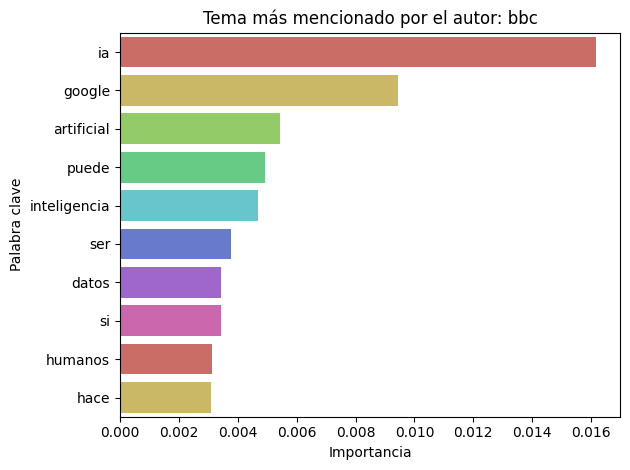

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


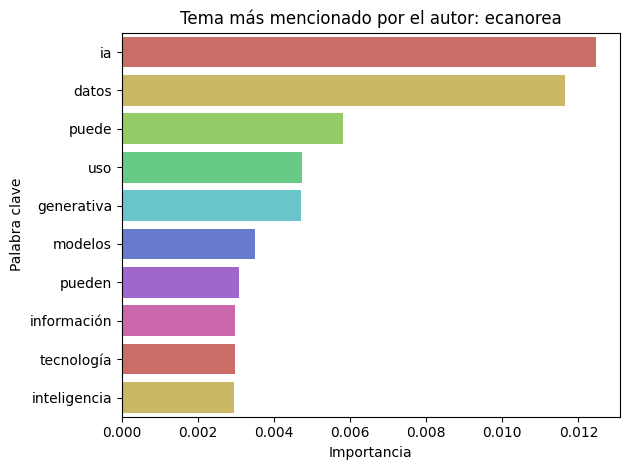

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


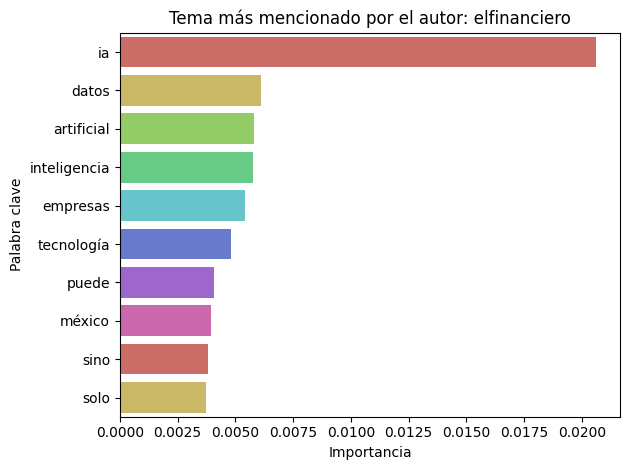

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


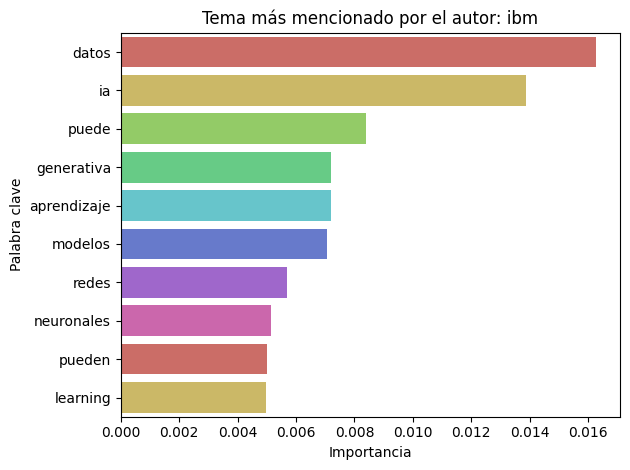

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


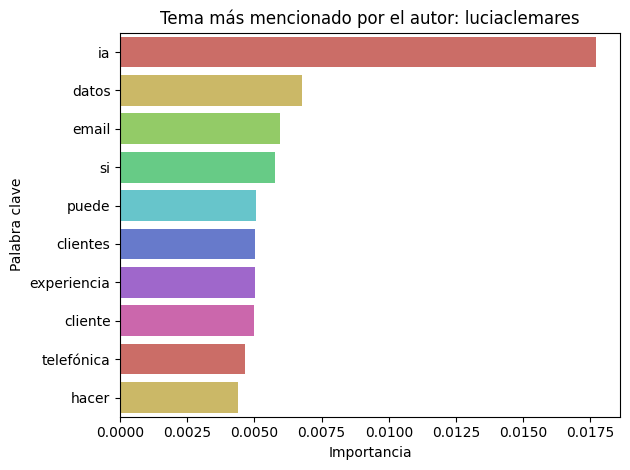

In [36]:
author_topics = {author: get_topics_by_author_LDA(top_5_author_data[top_5_author_data['Autor'] == author], 5) for author in top_5_authors}

# Gráficos para los autores
print("Generando gráficos para los autores...")
for author in top_5_authors:
    author_data = top_5_author_data[top_5_author_data['Autor'] == author]
    topic_distribution = get_topic_distribution_LDA(author_data)
    plot_topic_distribution(
        topic_distribution,
        f"Tema más mencionado por el autor: {author}",
        "Importancia",
        "Palabra clave"
    )

Generando gráficos para las fuentes...


C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


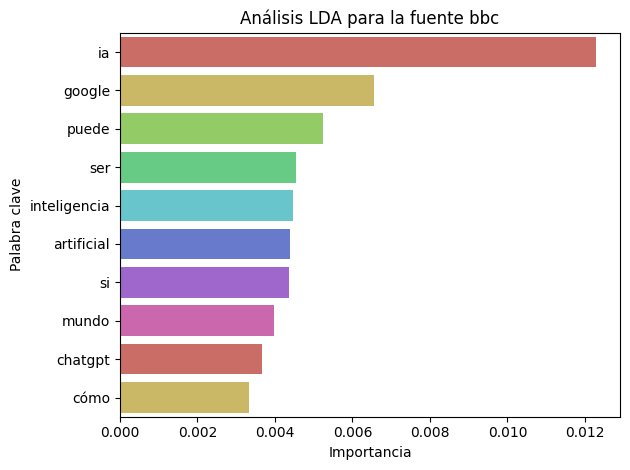

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


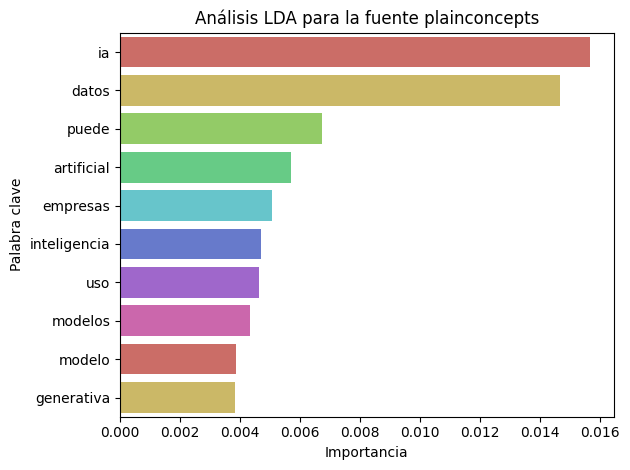

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


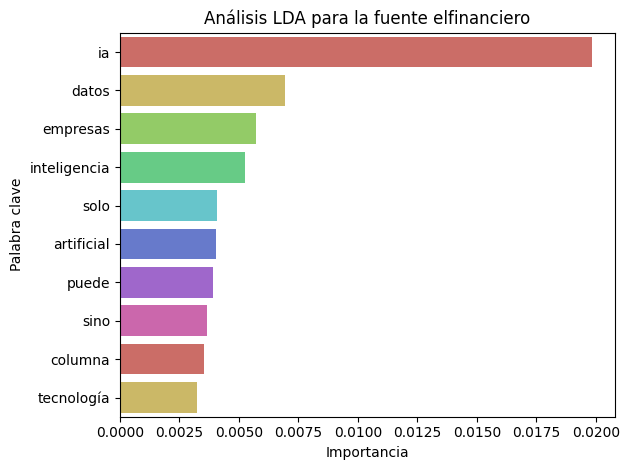

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


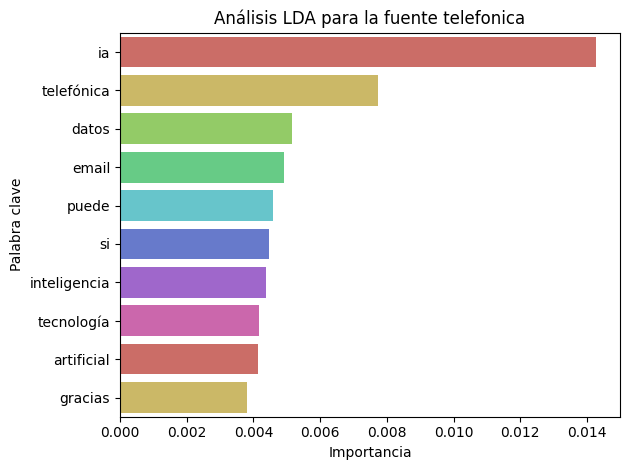

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


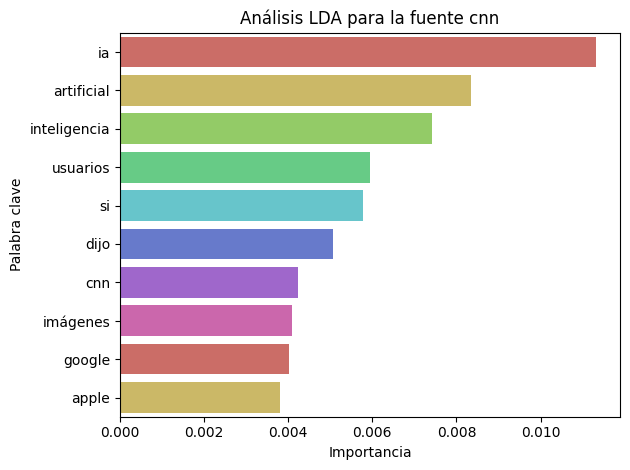

In [37]:
source_topics = {source: get_topics_by_source(top_5_source_data[top_5_source_data['NombreSitio'] == source], 5) for source in top_5_sources}

# Gráficos para las fuentes
print("Generando gráficos para las fuentes...")
for source in top_5_sources:
    source_data = top_5_source_data[top_5_source_data['NombreSitio'] == source]
    topic_distribution = get_topic_distribution_LDA(source_data)
    plot_topic_distribution(
        topic_distribution,
        f"Análisis LDA para la fuente {source}",
        "Importancia",
        "Palabra clave"
    )


In [38]:
# Función para limpiar y tokenizar los textos
def preprocess_text_NMF(text):
    tokens = nltk.word_tokenize(text.lower())  # Convertir a minúsculas y tokenizar
    tokens = [t for t in tokens if t.isalpha() and t not in ENGLISH_STOP_WORDS and t not in custom_stopwords]
    return " ".join(tokens)  # Devolver el texto limpio como una cadena

In [39]:
df_nuevo['Contenido'] = df_nuevo['Contenido'].apply(preprocess_text_NMF)

# Contar los 5 autores más frecuentes
top_5_authors = df_nuevo['Autor'].value_counts().head(5).index

# Filtrar el dataframe para cada autor
top_5_author_data = df_nuevo[df_nuevo['Autor'].isin(top_5_authors)]

# Contar las 5 fuentes más frecuentes
top_5_sources = df_nuevo['NombreSitio'].value_counts().head(5).index

# Filtrar el dataframe para cada fuente
top_5_source_data = df_nuevo[df_nuevo['NombreSitio'].isin(top_5_sources)]

In [40]:
# Función para obtener la distribución de palabras del tema más mencionado
def get_topic_distribution_NMF(data, num_topics=5):
    # Usamos CountVectorizer para convertir los tokens en una matriz de términos
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(data['Contenido'])

    # Aplicamos NMF
    nmf = NMF(n_components=num_topics, random_state=1)
    nmf.fit(X)

    # Obtener el tema más relevante (primer tema del modelo)
    topic_words = nmf.components_[0]  # Las palabras más importantes del primer tema
    terms = vectorizer.get_feature_names_out()
    return {terms[i]: topic_words[i] for i in topic_words.argsort()[-10:]}  # Top 10 palabras


# Aplicar NMF para cada autor
def get_topics_by_author_NMF(author_data, num_topics=5):
    # Usamos CountVectorizer para convertir el texto en una matriz de términos
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(author_data['Contenido'])

    # Aplicamos NMF
    nmf = NMF(n_components=num_topics, random_state=1)
    nmf.fit(X)

    # Obtener los temas
    topic_words = {}
    for idx, topic in enumerate(nmf.components_):
        terms = vectorizer.get_feature_names_out()
        topic_words[idx] = {terms[i]: topic[i] for i in topic.argsort()[-10:]}  # Top 10 palabras por tema

    return topic_words


# Aplicar NMF para cada fuente
def get_topics_by_source_NMF(source_data, num_topics=5):
    # Usamos CountVectorizer para convertir el texto en una matriz de términos
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(source_data['Contenido'])

    # Aplicamos NMF
    nmf = NMF(n_components=num_topics, random_state=1)
    nmf.fit(X)

    # Obtener los temas
    topic_words = {}
    for idx, topic in enumerate(nmf.components_):
        terms = vectorizer.get_feature_names_out()
        topic_words[idx] = {terms[i]: topic[i] for i in topic.argsort()[-10:]}  # Top 10 palabras por tema

    return topic_words

Generando gráficos para los autores...


C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


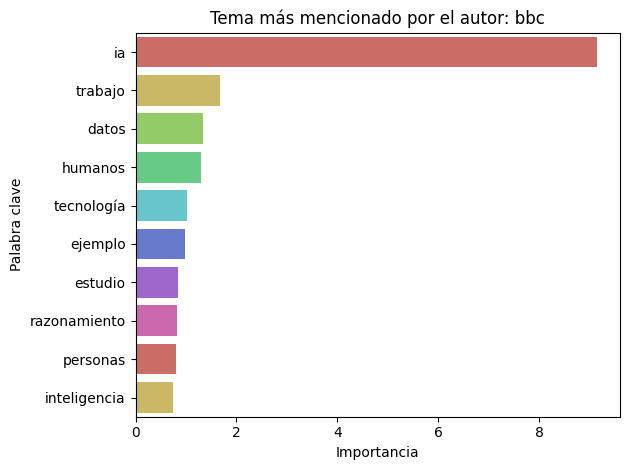

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


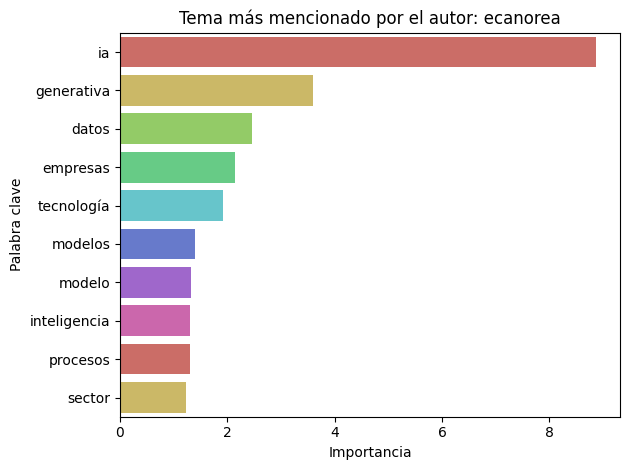

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


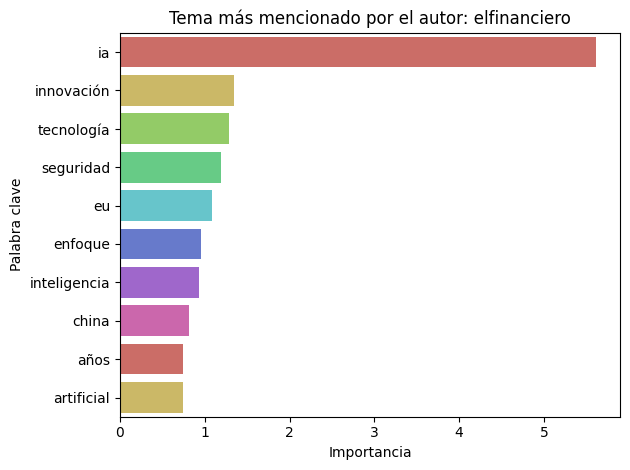

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


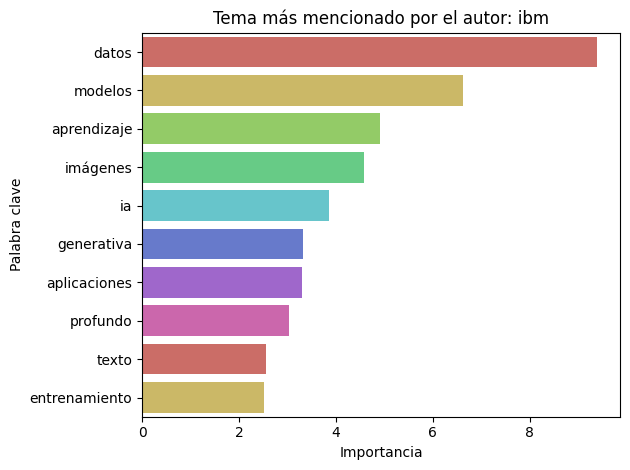

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


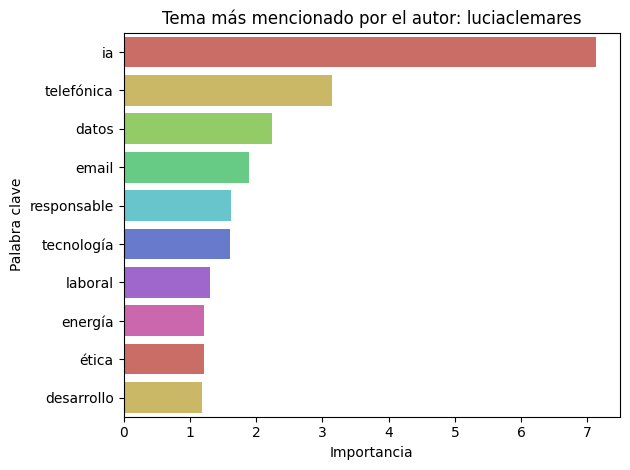

In [41]:
author_topics = {author: get_topics_by_author_NMF(top_5_author_data[top_5_author_data['Autor'] == author], 5) for author in top_5_authors}

# Gráficos para los autores
print("Generando gráficos para los autores...")
for author in top_5_authors:
    author_data = top_5_author_data[top_5_author_data['Autor'] == author]
    topic_distribution = get_topic_distribution_NMF(author_data)

    # Ordenar el topic_distribution de mayor a menor
    sorted_topic_distribution = dict(sorted(topic_distribution.items(), key=lambda x: x[1], reverse=True))

    plot_topic_distribution(
        sorted_topic_distribution,  # Usar la distribución ordenada
        f"Tema más mencionado por el autor: {author}",
        "Importancia",
        "Palabra clave"
    )

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


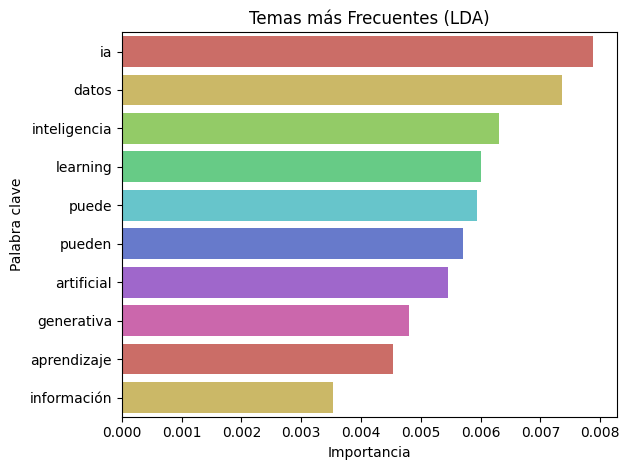

In [42]:
# Realiza el análisis LDA para todos los documentos
def get_topic_distribution_LDA_all(data, num_topics=5):
    dictionary = corpora.Dictionary(data['tokens'])
    corpus = [dictionary.doc2bow(text) for text in data['tokens']]
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    topics = lda.show_topics(num_topics=num_topics, formatted=False)

    # Extraer el tema más relevante (primer tema del modelo)
    topic_words = topics[0][1]  # Lista de (palabra, probabilidad)
    return {word: prob for word, prob in topic_words}

# Aplicar LDA y graficar
topic_distribution_lda = get_topic_distribution_LDA_all(df_nuevo, num_topics=5)
plot_topic_distribution(
    topic_distribution_lda,
    "Temas más Frecuentes (LDA)",
    "Importancia",
    "Palabra clave"
)

C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\gamen\AppData\Local\Temp\ipykernel_6712\2960277688.py:6: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


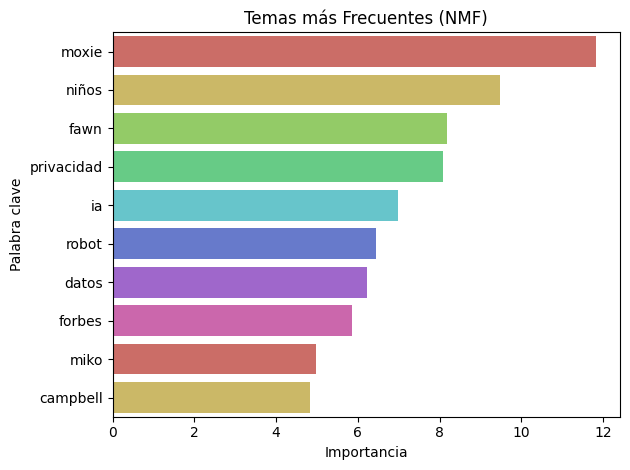

In [43]:
# Función para obtener la distribución de palabras más relevante en NMF
def get_topic_distribution_NMF_all(data, num_topics=5):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(data['Contenido'])

    nmf = NMF(n_components=num_topics, random_state=1)
    nmf.fit(X)

    # Extraer el tema más relevante (primer tema del modelo)
    topic_words = nmf.components_[0]  # Las palabras más importantes del primer tema
    terms = vectorizer.get_feature_names_out()

    # Crear un diccionario con las palabras y sus relevancias
    topic_dict = {terms[i]: topic_words[i] for i in topic_words.argsort()[-10:]}  # Top 10 palabras
    sorted_topic_dict = dict(sorted(topic_dict.items(), key=lambda x: x[1], reverse=True))  # Ordenar de mayor a menor

    return sorted_topic_dict

# Aplicar NMF y graficar
topic_distribution_nmf = get_topic_distribution_NMF_all(df_nuevo, num_topics=5)
plot_topic_distribution(
    topic_distribution_nmf,
    "Temas más Frecuentes (NMF)",
    "Importancia",
    "Palabra clave"
)

In [46]:
!pip install flair

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\gamen\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [51]:
# Crear un DataFrame con los autores únicos
autores_unicos = df_metadatos[['Autor']].drop_duplicates().reset_index(drop=True)

autores_unicos


,Autor
0,wikipedia
1,ibm
2,xataka
3,unir
4,sas
...,...
445,cedim
446,mesaparticipacion
447,cronica
448,Maria Ovelar


In [54]:
import pandas as pd
import spacy

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Limpieza: Convertir a texto y manejar valores nulos
autores_unicos['Autor'] = autores_unicos['Autor'].fillna("").astype(str)

# Función para obtener el tipo de entidad nombrada
def obtener_tipo(texto):
    doc = nlp(texto)
    # Iterar sobre entidades reconocidas
    for ent in doc.ents:
        return ent.label_  # Devuelve el tipo de la primera entidad encontrada
    return "Sin tipo"  # Si no se encuentra ninguna entidad

# Aplicar la función al DataFrame de autores
autores_unicos['tipo'] = autores_unicos['Autor'].apply(obtener_tipo)

# Mostrar el resultado
autores_unicos


,Autor,tipo
0,wikipedia,MISC
1,ibm,ORG
2,xataka,LOC
3,unir,ORG
4,sas,Sin tipo
...,...,...
445,cedim,LOC
446,mesaparticipacion,MISC
447,cronica,Sin tipo
448,Maria Ovelar,PER


In [55]:
# Diccionario para interpretar las etiquetas
interpretaciones = {
    "PER": "Persona (individuo)",
    "LOC": "Lugar o ubicación",
    "ORG": "Organización",
    "MISC": "Misceláneo (otros)",
    "Sin tipo": "No identificado"
}

# Crear la columna 'tipo_autor' basándose en el diccionario
autores_unicos['tipo_autor'] = autores_unicos['tipo'].map(interpretaciones)

# Mostrar el resultado
autores_unicos


,Autor,tipo,tipo_autor
0,wikipedia,MISC,Misceláneo (otros)
1,ibm,ORG,Organización
2,xataka,LOC,Lugar o ubicación
3,unir,ORG,Organización
4,sas,Sin tipo,No identificado
...,...,...,...
445,cedim,LOC,Lugar o ubicación
446,mesaparticipacion,MISC,Misceláneo (otros)
447,cronica,Sin tipo,No identificado
448,Maria Ovelar,PER,Persona (individuo)


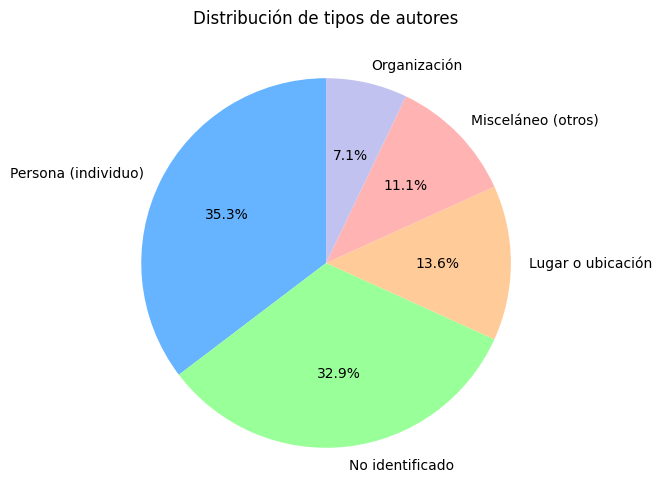

In [56]:
import matplotlib.pyplot as plt

# Contar la cantidad de cada tipo de autor en la columna 'tipo_autor'
tipo_autor_counts = autores_unicos['tipo_autor'].value_counts()

# Crear gráfico de pastel
plt.figure(figsize=(8, 6))
tipo_autor_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ffcc99', '#ffb3b3', '#c2c2f0'])
plt.title('Distribución de tipos de autores')
plt.ylabel('')  # Eliminar la etiqueta del eje y
plt.show()


In [59]:
# Filtrar el DataFrame para mostrar solo las filas donde el autor es una persona
autores_persona = autores_unicos[autores_unicos['tipo_autor'] == 'Persona (individuo)']

# Mostrar el resultado
autores_persona

,Autor,tipo,tipo_autor
6,amazon,PER,Persona (individuo)
18,Ana Medina,PER,Persona (individuo)
19,Yilda Morillo,PER,Persona (individuo)
25,Daniel,PER,Persona (individuo)
30,José Luis Sarmiento-Ramos,PER,Persona (individuo)
...,...,...,...
436,europarl,PER,Persona (individuo)
438,Robotnik,PER,Persona (individuo)
443,esdelatino,PER,Persona (individuo)
444,Pia Ceres,PER,Persona (individuo)
